In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from flow import sample_images
from transforms import radon
from utils import load_checkpoint
from torchdiffeq import odeint
import time
from torch import optim
from torchmetrics import CatMetric
from unet import Unet

/home/johnma/d-flow/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/johnma/d-flow/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [3]:
torch.manual_seed(159753)
np.random.seed(159753)

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
%%capture
im_size = 128
checkpoint_path = f'checkpoints/{im_size}x{im_size}/ckp_3906.tar'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# this channel parameter needs to match whatever model you are actually loading
model = Unet(ch=im_size).to(device)

# ema_model = torch.optim.swa_utils.AveragedModel(
#     model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.9999)
# )
_, _, model, _, _, _= load_checkpoint(model=model, path=checkpoint_path)
model.eval()

In [5]:
from typing import Callable, Dict, List, Optional

from torch import autocast
from torchdiffeq import odeint_adjoint 
import torch.nn as nn

def inverse_loss_fn(x, y):
    """
    Loss function for the inverse problem.
    """
    device = x.device
    if isinstance(x, np.ndarray):
        x= torch.tensor(x, device=device, dtype=torch.float32)
    if isinstance(y, np.ndarray):
        y = torch.tensor(y, device=device, dtype=torch.float32)

    x = x.float()
    y = y.float()


    loss = torch.mean((x - y) ** 2)

    return loss
    
def ode_integrate(ode_func: nn.Module,
                  init_x: torch.Tensor,
                  ode_opts: Dict = {},
                  t_eps: float = 0,
                  init_t: float = 0.,
                  final_t: float = 1.,
                  t_arr: Optional[List[float]] = None,
                  num_steps: int = 5,
                  intermediate_points: bool = False
      ) -> torch.Tensor:

    if t_arr is None:
        t = torch.linspace(init_t - t_eps, final_t, num_steps).to(init_x.device)
    else:
        t = torch.tensor(t_arr, dtype=torch.float32, device=init_x.device)

    ode_opts = {
        "atol": 1e-5, 
        "rtol": 1e-5, 
        "method": "euler", 
        **ode_opts
    }

    z = odeint(
        func = lambda t, x: ode_func(x, t.expand(x.shape[0])),
        y0 = init_x,
        t = t,
        **ode_opts
    )

    if not intermediate_points:
        return z[-1]
    return z


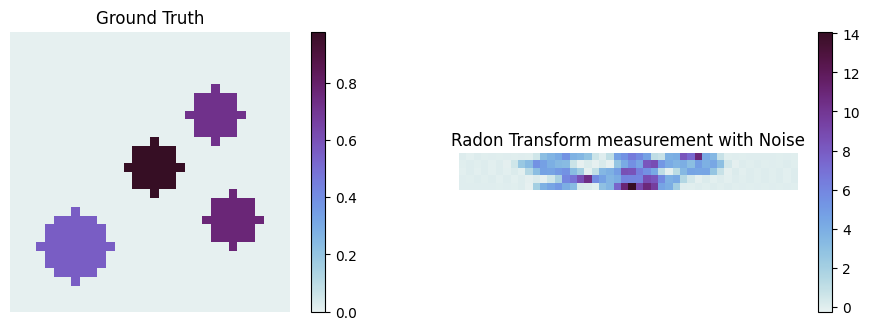

In [6]:
# load data and select a random ground truth from test set
test_data = torch.load(f'data/dataset-{im_size}.pt')["test"]
idx = np.random.randint(0, len(test_data))
gt = test_data[idx].to(device).unsqueeze(0)

# apply radon transform, and apply multiplicative noise
img_radon = radon.radon_transform(gt.squeeze().cpu().numpy(), N=5)
img_radon = torch.tensor(img_radon, device=device, dtype=torch.float32).unsqueeze(0)
img_radon = img_radon.unsqueeze(0)  # add batch dimension   

# mult noise
img_radon = (1 + 0.1 * torch.randn_like(img_radon)) * img_radon
# plot gt, plot img_radon, plot initial guess in x_0 space, and plot flow realization
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(gt.squeeze().cpu().numpy(), cmap=cmocean.cm.dense)
plt.title('Ground Truth')
plt.axis('off')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(img_radon.squeeze().cpu().numpy(), cmap=cmocean.cm.dense)
plt.title('Radon Transform measurement with Noise')
plt.axis('off')
plt.colorbar()

In [7]:
# getting normalization constants
train_min, train_max = torch.min(torch.load(f'data/dataset-{im_size}.pt')["train"]), torch.max(torch.load(f'data/dataset-{im_size}.pt')["train"])

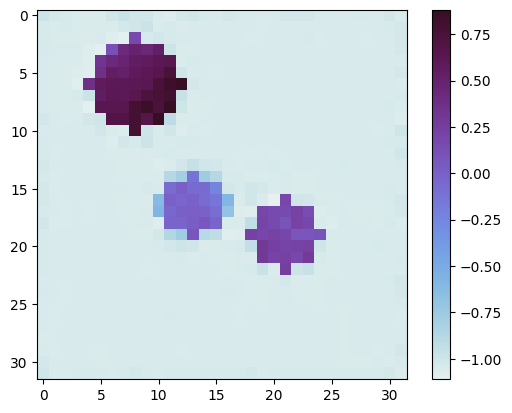

In [8]:
# test model out quickly
# with torch.autograd.profiler.profile(use_device='cuda') as prof:
img = sample_images(model, (1,1,im_size,im_size), num_steps=5, device=device)
# print(prof.key_averages().table(sort_by="cuda_time_total"))
img = img[-1].squeeze().cpu().numpy()
plt.imshow(img, cmap=cmocean.cm.dense)
plt.colorbar() # note that our flow model is normalized to [-1,1]

In [9]:
from torch.func import vmap, jvp, vjp
def sketch_jacobian(oversampling_param: int,
                    sketch_dim: int,
                    jac_dim: int,
                    model: nn.Module,
                    ode_integrate: Callable,
                    x0: torch.Tensor,
                    num_steps: int = 5,
                    intermediate_points: bool = False,
                    ) -> torch.Tensor:
    # rangefinder step
    ell = sketch_dim + oversampling_param
    x0_detached = x0.detach().clone().requires_grad_(False)
    # we sample images 32x32 and we compute jacobian vector products via jvp, then convert the outputs to vectors
    # those vectors are the columns of Y
    # we use jvp to form Y but we can easily also use finite difference
    def f(x_):
        x1 = ode_integrate(model, x_, num_steps=num_steps, intermediate_points=intermediate_points)
        # unnormalize
        x1 = 0.5 * (x1 + 1.0) * (train_max - train_min) + train_min
        return x1
        
    # we can do some vectorizing here using vmap
    Y = torch.zeros(jac_dim, ell).to(x0_detached.device)

    # Vectorize jvp computation using vmap for efficiency

    def single_jvp(omega):
        return jvp(f, (x0_detached,), (omega.unsqueeze(0),))[1].view(im_size*im_size)

    with torch.no_grad():
        omegas = torch.randn(ell, 1, im_size, im_size, device=x0.device)
        Y = vmap(single_jvp)(omegas).T  # shape: (jac_dim, ell)
        # compute QR 
        Q_range, _ = torch.linalg.qr(Y, mode='reduced')
        del Y, omegas
        torch.cuda.empty_cache() if x0.device.type == 'cuda' else None
    with torch.no_grad():
        _, vjp_fn = vjp(f, x0_detached)
        Q_out = Q_range.reshape(im_size * im_size, ell)
        Q_out_imgs = Q_out.T.reshape(ell, *f(x0_detached).shape)

        def apply_vjp(v_cotangent):
            return vjp_fn(v_cotangent)[0].reshape(-1)

        B = vmap(apply_vjp)(Q_out_imgs)

        U_tilde, S, Vh = torch.linalg.svd(B, full_matrices=False)
        del B, Q_out_imgs, vjp_fn
        torch.cuda.empty_cache() if x0.device.type == 'cuda' else None
        U = Q_range @ U_tilde
        res = (U @ torch.diag(S)) @ Vh
        del U_tilde, S, Vh, Q_range, U
        torch.cuda.empty_cache() if x0.device.type == 'cuda' else None
    return res



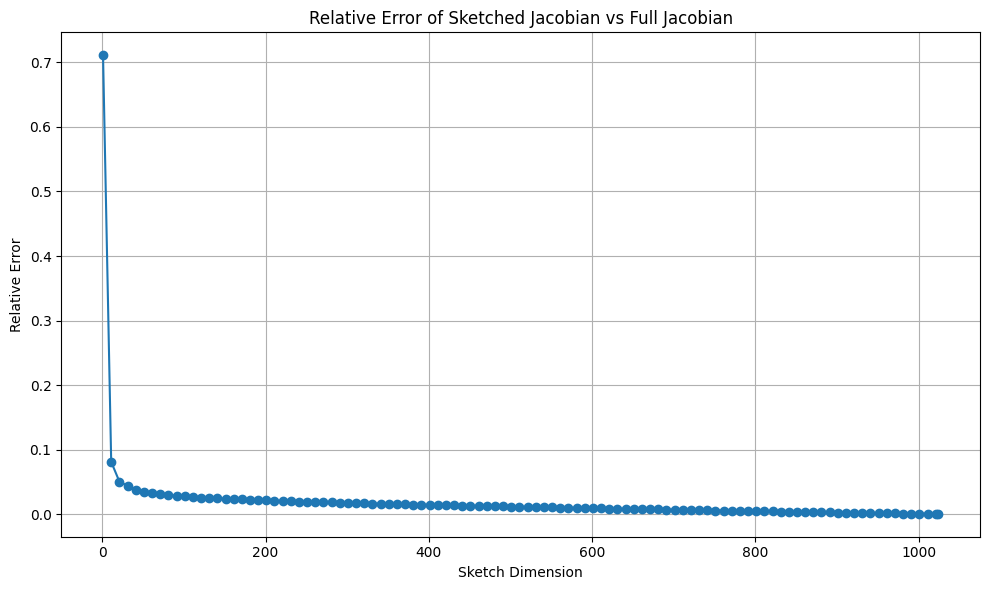

In [12]:
# test our function out by comparing against the full Jacobian
sampling_params = list(range(1, 1025, 10))
sampling_params.append(1024) 
rel_errors = []
x0 = torch.randn((1, 1, im_size, im_size), device=device, dtype=torch.float32)
num_steps = 5
intermediate_points = False
def f(x_):
    x1 = ode_integrate(model, x_, num_steps=num_steps, intermediate_points=intermediate_points)
    # unnormalize
    x1 = 0.5 * (x1 + 1.0) * (train_max - train_min) + train_min
    return x1
full_jacobian = torch.autograd.functional.jacobian(
    f,
    x0,
    create_graph=False
).view(im_size * im_size, im_size * im_size)
for sketch_dim in sampling_params:
    sketched_jacobian = sketch_jacobian(oversampling_param=0, 
                                sketch_dim=sketch_dim, # Large sketch dimension should capture almost all the actual Jacobian
                                jac_dim=im_size*im_size, 
                                model=model, 
                                ode_integrate=ode_integrate, 
                                x0=x0, 
                                num_steps=5, 
                                intermediate_points=False
                                )
    # compute L2 distance
    l2_distance = torch.norm(sketched_jacobian - full_jacobian, p=2)
    # relative error
    relative_error = l2_distance / torch.norm(full_jacobian, p=2)

    rel_errors.append(relative_error.item())

# make a pretty plot of the relative errors
plt.figure(figsize=(10, 6))
plt.plot(sampling_params, rel_errors, marker='o')
plt.xlabel('Sketch Dimension')
plt.ylabel('Relative Error')
plt.title('Relative Error of Sketched Jacobian vs Full Jacobian')
plt.grid()
plt.tight_layout()


In [22]:
from tqdm import tqdm
# here is some code to just try running steepest descent / sgd using sketching
optim_steps = 10000
x0 = torch.randn((1, 1, im_size, im_size), device=device, dtype=torch.float32)
sketch_dim = 50
oversampling_param = 10
x1_traj = []
y = img_radon.clone().to(device)
eta = 1
losses = []
target_loss = .005 # I would be amazed!
# Initialize progress bar
pbar = tqdm(range(optim_steps), desc="Steepest Descent")

for step in pbar:
    # compute sketch of jacobian at x1
    jac_dim = im_size * im_size
    sketched_jacobian = sketch_jacobian(oversampling_param=oversampling_param, 
                                sketch_dim=sketch_dim, 
                                jac_dim=jac_dim, 
                                model=model, 
                                ode_integrate=ode_integrate, 
                                x0=x0, 
                                num_steps=5, 
                                intermediate_points=False
                                )
    # integrate x0
    x1 = ode_integrate(model, x0, num_steps=5, intermediate_points=False)
    x1 = 0.5 * (x1 + 1.0) * (train_max - train_min) + train_min
    # apply forward operator, << I'm not adding noise here
    x1_radon = radon.radon_transform(x1, N=5)
    loss = inverse_loss_fn(x1, gt)
    # use autodiff to compute grad_{x_1} L(x_1) << which is not computationally hard hopefully
    grad_x1 = torch.autograd.grad(inverse_loss_fn(x1_radon, y), x1, create_graph=False)[0]
    grad_x1 = grad_x1.view(im_size * im_size)
    # compute grad_{x_0} L(x_1) using chain rule
    loss_grad = sketched_jacobian.T @ grad_x1

    # update x0 using the computed gradient
    x0 = x0 - eta * loss_grad.view_as(x0)
    x1_traj.append(x1.detach().clone().cpu().numpy())
    # Update progress bar with loss
    pbar.set_postfix({'Loss': f'{loss.item():.6f}'})
    if step % 100 == 0:
        losses.append(loss)
    if loss < target_loss:
        print(f"Target loss reached at step {step}, Loss: {loss.item():.6f}")
        break

Steepest Descent:   0%|          | 0/10000 [00:00<?, ?it/s]

Steepest Descent:   4%|▍         | 434/10000 [05:23<1:58:56,  1.34it/s, Loss=0.022879]


KeyboardInterrupt: 

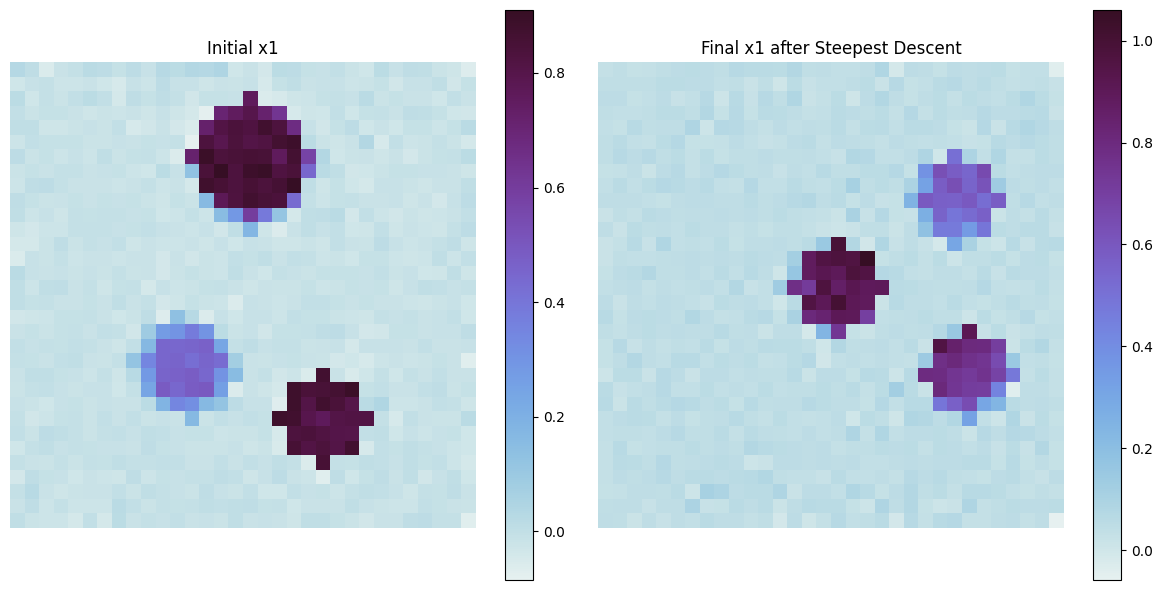

In [23]:
# plot initial x1 : x1_traj[0]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im1 = axes[0].imshow(x1_traj[0].squeeze(), cmap=cmocean.cm.dense)
axes[0].set_title('Initial x1')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])
# final x1
im2 = axes[1].imshow(x1_traj[-1].squeeze(), cmap=cmocean.cm.dense)
axes[1].set_title('Final x1 after Steepest Descent')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1])
plt.tight_layout()


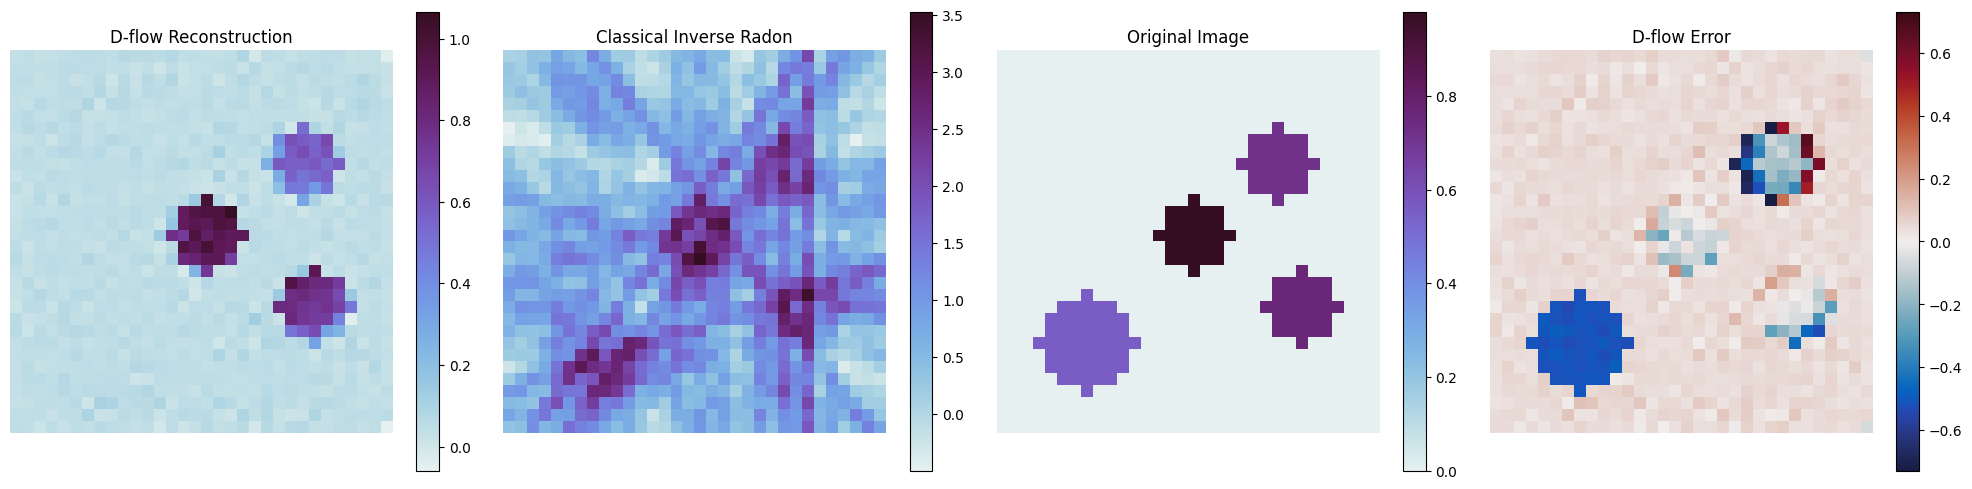

D-flow Results
MSE: 0.022806
MAE: 0.082342
PSNR: 16.23 dB
Rel. L2 Error: 0.5579

Classical Inverse Radon Results
MSE: 1.061111
MAE: 0.863529
PSNR: -0.44 dB
Rel. L2 Error: 3.8056


In [24]:
import warnings
x1 = ode_integrate(model, x0, num_steps=5, intermediate_points=False)
x1 = 0.5 * (x1 + 1.0) * (train_max - train_min) + train_min
x1_traj.append(x1.detach().clone().cpu().numpy())
# Suppress warnings from transforms
warnings.filterwarnings('ignore', category=RuntimeWarning)
np.seterr(divide='ignore', invalid='ignore')

# plot error and final result
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Reconstructed image (D-flow)
im1 = axes[0].imshow(x1.squeeze().detach().cpu().numpy(), cmap=cmocean.cm.dense)
axes[0].set_title('D-flow Reconstruction')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])

# Classical inverse radon transform
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    classical_recon = radon.iradon_transform(img_radon.squeeze().cpu().numpy())

im2 = axes[1].imshow(classical_recon.real, cmap=cmocean.cm.dense)
axes[1].set_title('Classical Inverse Radon')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1])

# Original image
im3 = axes[2].imshow(gt.squeeze().cpu().numpy(), cmap=cmocean.cm.dense)
axes[2].set_title('Original Image')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2])

# Error/difference (D-flow vs Original)
error = x1.squeeze().detach().cpu().numpy() - gt.squeeze().cpu().numpy()
im4 = axes[3].imshow(error, cmap=cmocean.cm.balance, vmin=-np.abs(error).max(), vmax=np.abs(error).max())
axes[3].set_title('D-flow Error')
axes[3].axis('off')
plt.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()

# Print comparison metrics
mse_dflow = np.mean(error**2)
mae_dflow = np.mean(np.abs(error))
psnr_dflow = 20 * np.log10(np.max(gt.squeeze().cpu().numpy()) / np.sqrt(mse_dflow))

error_classical = classical_recon.real - gt.squeeze().cpu().numpy()
mse_classical = np.mean(error_classical**2)
mae_classical = np.mean(np.abs(error_classical))
psnr_classical = 20 * np.log10(np.max(gt.squeeze().cpu().numpy()) / np.sqrt(mse_classical))

print("D-flow Results")
print(f"MSE: {mse_dflow:.6f}")
print(f"MAE: {mae_dflow:.6f}")
print(f"PSNR: {psnr_dflow:.2f} dB")
print(f"Rel. L2 Error: {np.linalg.norm(error) / np.linalg.norm(gt.squeeze().cpu().numpy()):.4f}")

print("\nClassical Inverse Radon Results")
print(f"MSE: {mse_classical:.6f}")
print(f"MAE: {mae_classical:.6f}")
print(f"PSNR: {psnr_classical:.2f} dB")
print(f"Rel. L2 Error: {np.linalg.norm(error_classical) / np.linalg.norm(gt.squeeze().cpu().numpy()):.4f}")
